In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.linear_model import LinearRegression as LR

2024-04-23 20:35:04.200086: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-23 20:35:04.201107: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-23 20:35:04.254910: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-23 20:35:04.472438: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-23 20:35:05.324970: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [2]:
directorio = '../newfile/latpar_project/LatPars_SuperModel/'

hfxrd = np.load(directorio + 'hf_0100.npy')
y = np.load('../newfile/latpar_project/latpars.npy')

In [3]:
db = pd.read_csv('../newfile/latpar_project/db_peaks.csv')

In [4]:
dftest = pd.read_csv(directorio + 'dftest.csv')
dftraval = pd.read_csv(directorio + 'dftraval.csv')

In [5]:
for row in range(db.shape[0]):    
    db.at[row,'name'] = db['name'][row][:7]

In [6]:
dftest = pd.read_csv(directorio + 'dftest.csv')
dftraval = pd.read_csv(directorio + 'dftraval.csv')

for row in range(dftest.shape[0]):
    dftest.at[row, 'name'] = dftest['name'][row][:7]
    
for row in range(dftraval.shape[0]):
    dftraval.at[row, 'name'] = dftraval['name'][row][:7]

ntest = dftest.shape[0]//4
ntraval = dftraval.shape[0]//4

dftest = dftest.iloc[:ntest,:].reset_index(drop=True)
dftraval = dftraval.iloc[:ntraval,:].reset_index(drop=True)

idxtraval = [i for i in db.loc[db.name.isin([i.split('_')[0] for i in dftraval.name.values])].index]
idxtest = [i for i in db.loc[db.name.isin([i.split('_')[0] for i in dftest.name.values])].index]


hftest = hfxrd[idxtest]
hftraval = hfxrd[idxtraval]
    
ytest = y[idxtest]
ytraval = y[idxtraval]

In [7]:
sgdiccio = pd.read_csv('../newfile/latpar_project/sgnum_cif.csv')
sgdiccio = {k:v for k,v in zip(sgdiccio.cif.values, sgdiccio.sgnum.values)}

dbtest = db.take(idxtest).reset_index(drop=True)
dbtraval = db.take(idxtraval).reset_index(drop=True)

dbtest['sgnum'] = [sgdiccio.get(int(i), None) for i in dbtest.name.values]
dbtraval['sgnum'] = [sgdiccio.get(int(i), None) for i in dbtraval.name.values]

In [8]:
cs = dict()

for n in range(1,231):
    
    if n <= 2: cs[n]  = 0;
    elif 2 < n <=15: cs[n] = 1;
    elif 15 < n <=74: cs[n] = 2;
    elif 74 < n <=142: cs[n] = 3;
    elif 142 < n <=167: cs[n] = 4;
    elif 167 < n <=194: cs[n] = 5;
    elif 194 < n <=230: cs[n] = 6;
        

In [9]:
dbtest['cs'] = [cs.get(i, None) for i in dbtest.sgnum.values]
dbtraval['cs'] = [cs.get(i, None) for i in dbtraval.sgnum.values]

Orthogonal vectors for crystal systems

In [10]:
orthoset = scipy.stats.ortho_group.rvs(32, random_state=3451)
csos_test = orthoset[dbtest.cs.values]
csos_traval = orthoset[dbtraval.cs.values]

Orthogonal vectors for space groups

In [11]:
sgoset = scipy.stats.ortho_group.rvs(230, random_state=3451)
sgos_traval = sgoset[dbtraval.sgnum.values-1]
sgos_test = sgoset[dbtest.sgnum.values-1]

In order to shape our insights we will now use an nn to find the performance with each crystal systems

In [13]:
def create_mlp(features = int, multiples = list, dropout = 0, name= 'multilayer_nn'):
    input_layer = tf.keras.Input((features,))

    for n, hl in enumerate(multiples):

        if n == 0: x = tf.keras.layers.Dense(hl*features)(input_layer)
        else: x = tf.keras.layers.Dense(hl*features)(x)

        x = tf.keras.layers.LayerNormalization()(x)

        if n != len(multiples) -1:
            x = tf.keras.layers.LeakyReLU(0.15)(x)
            x = tf.keras.layers.Dropout(dropout)(x)

    xs = tf.keras.layers.Dense(multiples[-1]*features)(input_layer)
    xs = tf.keras.layers.LayerNormalization()(xs)

    x = tf.keras.layers.Add()([x, xs])
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.Dropout(dropout)(x)

    x = tf.keras.layers.Dense(6)(x)

    return tf.keras.models.Model(inputs=input_layer, outputs=x, name=name)


# 1.-Model with raw features 

First we state the number of features in the raw feature dataset

In [54]:
multiples = [6,8]
features = hftraval.shape[-1]
epochs = 25
batch_size = 64
verbose=1

In [55]:
mmodelo_raw = create_mlp(features = features, multiples = multiples, dropout = 0.5, name='raw_features_mlp_cs')


modelo_raw.compile(loss='log_cosh', metrics =['MeanSquaredError'],
                      optimizer=tf.keras.optimizers.legacy.Adamax(beta_1=0.9, beta_2=0.999, lr=1e-3, decay=1e-8,))

saveas = 'raw_features_model'
import time
a = time.time()
modelCheckpoint=tf.keras.callbacks.ModelCheckpoint(str(saveas)+'.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='auto')
history = tf.keras.callbacks.History()
data = modelo_cs.fit(hftraval,ytraval, validation_data=(hftest,ytest), epochs=epochs,batch_size=batch_size, callbacks=[modelCheckpoint,history],shuffle=True, verbose=verbose)

loss_log = data.history['loss']
val_loss_log = data.history['val_loss']
mat = np.vstack((loss_log, val_loss_log)).T
dataframe1 = pd.DataFrame(data=mat)
dataframe1.to_csv(str(saveas)+'.csv', sep=',', header=False, float_format='%.7f', index=False)
b = time.time()
print(b-a)
plt.figure()
plt.scatter(np.arange(mat.shape[0]), mat[:,0], color = 'blue', marker='o', label='training', s=10)
plt.scatter(np.arange(mat.shape[0]), mat[:,1], color = 'red', marker='x', label='test', s=10)
plt.legend(loc='best')
plt.show()

AttributeError: module 'keras.optimizers.legacy' has no attribute 'Adamax'

In [36]:
modelo_raw = tf.keras.models.load_model('./raw_features_model.h5')


/home/luismichel/.local/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/home/luismichel/.local/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Now lets test our model with each crystal system

In order to archieve this, we have to divide our hftest and ytest by crystal system and then predict and plot them

In [37]:
crystalsys = {}

for i in range(7):
    system = [dbtest.cs.values == i]
    system = np.array(system)
    system = system.reshape(15454,)
    
    crystalsys[f'system{i}'] = {'x' : hftest[system],
                                  'y': ytest[system] }

155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


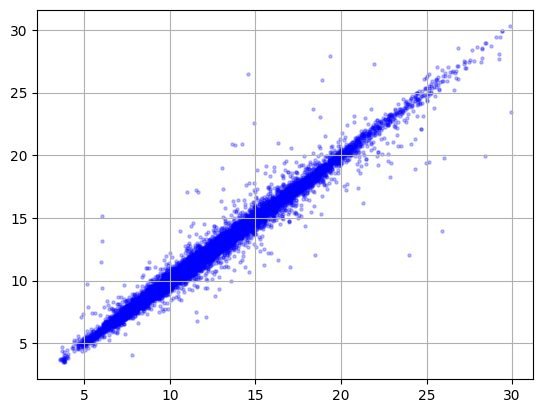

0.564600993405973
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


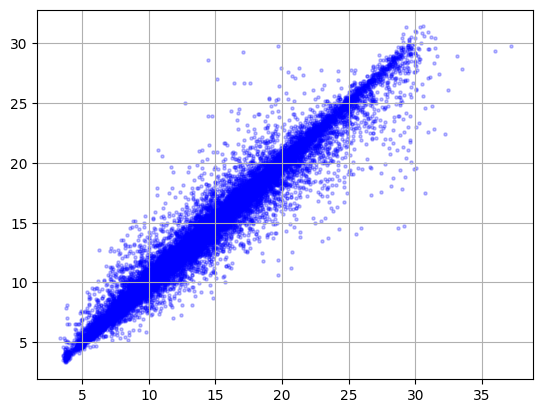

1.1299319307034574
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


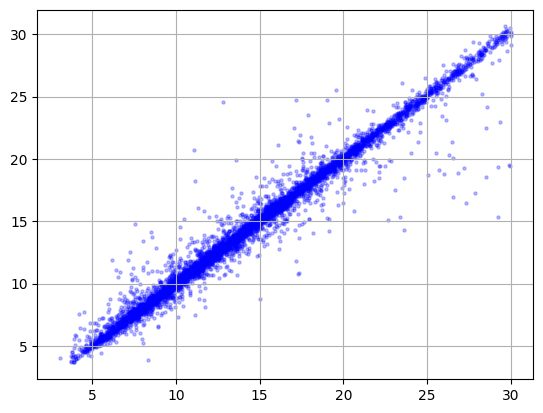

0.9257962824923842
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


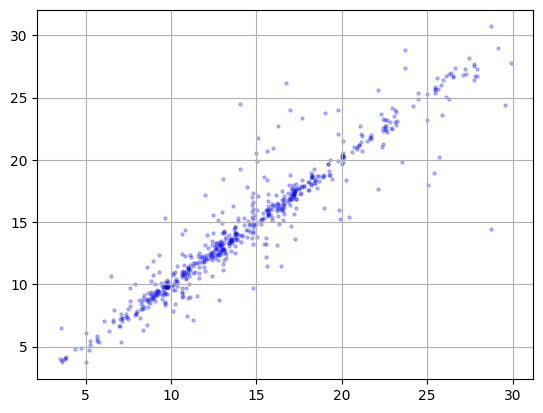

1.6939569170086055
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


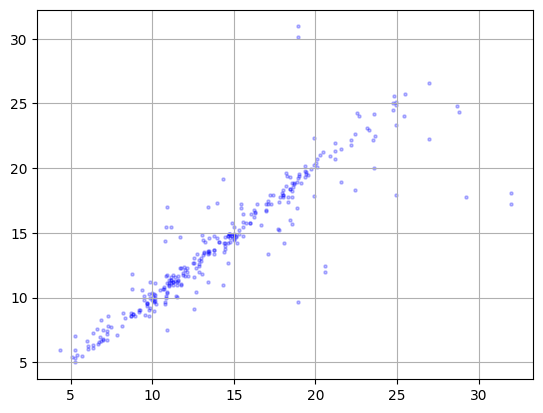

2.2705241245178205
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


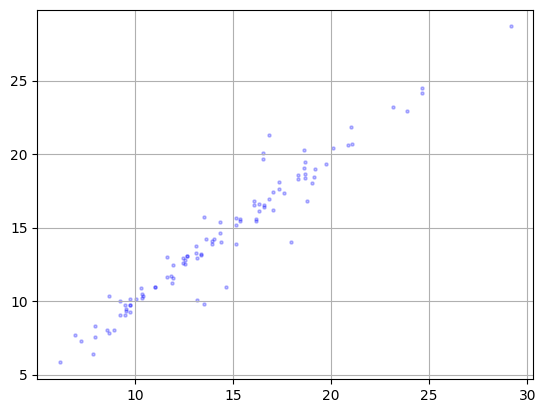

1.1506693679964786
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


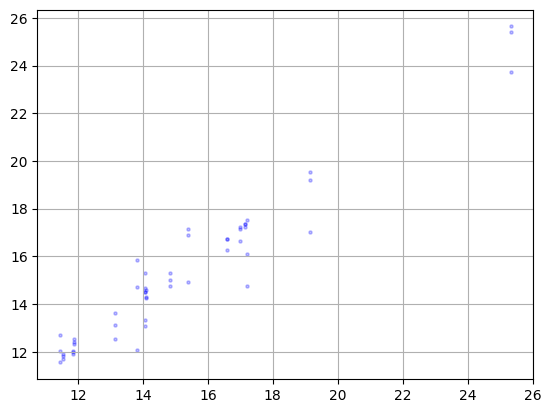

0.8466366020567156
483/483 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [62]:

for i in range(7):
    
    ptestnn = modelo_raw.predict(crystalsys[f'system{i}']['x'])
    
    plt.figure()
    plt.scatter(crystalsys[f'system{i}']['y'][:,:3], ptestnn[:,:3], s=5, color='blue', alpha=0.25)
    plt.grid()
    plt.show()
    
    rmse = ((ptestnn[:,:3] - crystalsys[f'system{i}']['y'][:,:3])**2).mean()**0.5
    
    res.loc['Model A', f'CS {i+1}'] = rmse
    print(rmse)


483/483 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


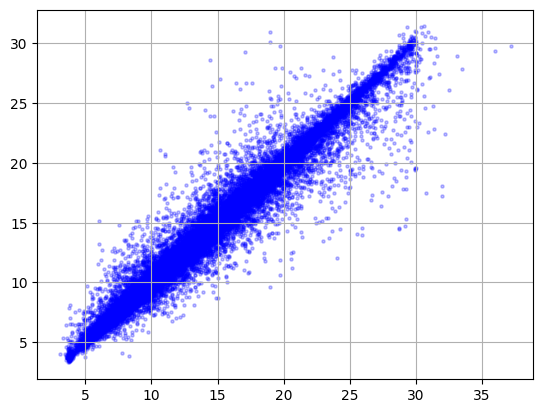

In [57]:
ptestnn = modelo_raw.predict(hftest)

rmse = ((ptestnn[:,:3] - ytest[:,:3])**2).mean()**0.5

plt.figure()
plt.scatter(ytest[:,:3], ptestnn[:,:3], s=5, color='blue', alpha=0.25)
plt.grid()
plt.show()

## 2.-Model with orthonormal vectors (raw features + crystal systems)

In [17]:
rctest = np.concatenate((hftest, csos_test), axis=-1)
rctraval = np.concatenate((hftraval, csos_traval), axis=-1)

In [18]:
features = rctraval.shape[-1]

In [17]:
modelo_cs = create_mlp(features = features, multiples = multiples, dropout = 0.5, name='rawncrys_mlp_cs')


modelo_cs.compile(loss='log_cosh', metrics =['MeanSquaredError'],
                      optimizer=tf.keras.optimizers.legacy.Adamax(beta_1=0.9, beta_2=0.999, lr=1e-3, decay=1e-8,))

modelCheckpoint=tf.keras.callbacks.ModelCheckpoint('rawncrys_model.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='auto')
history = tf.keras.callbacks.History()
data = modelo_cs.fit(rctraval,ytraval, validation_data=(rctest,ytest), epochs=25,batch_size=batch_size, callbacks=[modelCheckpoint,history],shuffle=True, verbose=verbose)

plt.figure()
plt.scatter(np.arange(mat.shape[0]), mat[:,0], color = 'blue', marker='o', label='training', s=10)
plt.scatter(np.arange(mat.shape[0]), mat[:,1], color = 'red', marker='x', label='test', s=10)
plt.legend(loc='best')
plt.show()

C:\Users\lmich\anaconda3\Lib\site-packages\keras\src\optimizers\legacy\adamax.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/25


3209/3209 [==============================] - ETA: 0s - loss: 0.2133 - mean_squared_error: 0.7547

C:\Users\lmich\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3209/3209 [==============================] - 305s 95ms/step - loss: 0.2133 - mean_squared_error: 0.7547 - val_loss: 0.1616 - val_mean_squared_error: 0.5876
Epoch 2/25
3209/3209 [==============================] - 303s 94ms/step - loss: 0.0923 - mean_squared_error: 0.2288 - val_loss: 0.1404 - val_mean_squared_error: 0.5311
Epoch 3/25
3209/3209 [==============================] - 303s 94ms/step - loss: 0.0787 - mean_squared_error: 0.1909 - val_loss: 0.1372 - val_mean_squared_error: 0.5265
Epoch 4/25
3209/3209 [==============================] - 301s 94ms/step - loss: 0.0726 - mean_squared_error: 0.1749 - val_loss: 0.1374 - val_mean_squared_error: 0.5202
Epoch 5/25
3209/3209 [==============================] - 302s 94ms/step - loss: 0.0690 - mean_squared_error: 0.1654 - val_loss: 0.1309 - val_mean_squared_error: 0.5102
Epoch 6/25
3209/3209 [==============================] - 302s 94ms/step - loss: 0.0666 - mean_squared_error: 0.1591 - val_loss: 0.1299 - val_mean_squared_error: 0.5078
Epoch 7/2

NameError: name 'saveas' is not defined

In [19]:
modelo_cs = tf.keras.models.load_model('./rawncrys_model.h5')

metrics by crystal system

In [20]:
crystalsys = {}

for i in range(7):
    system = [dbtest.cs.values == i]
    system = np.array(system)
    system = system.reshape(15454,)
    
    crystalsys[f'system{i}'] = {'x' : rctest[system],
                                  'y': ytest[system] }

155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


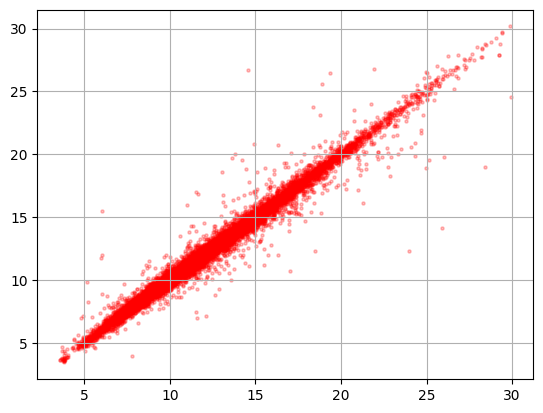

0.5476331292428505
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


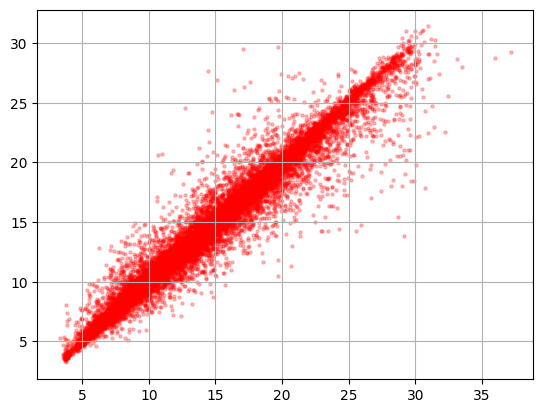

1.121460366605905
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


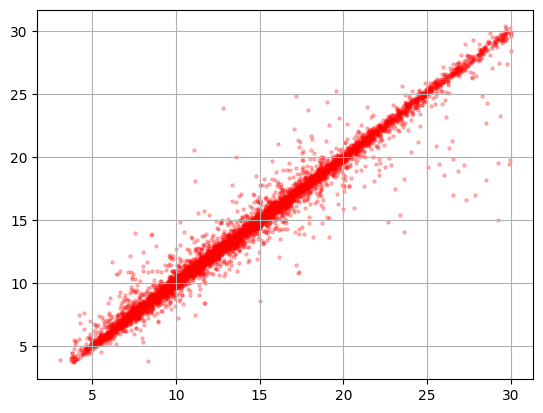

0.9090618448753373
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


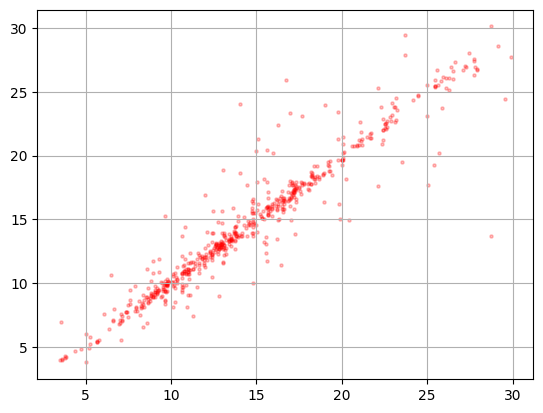

1.6342882009707465
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


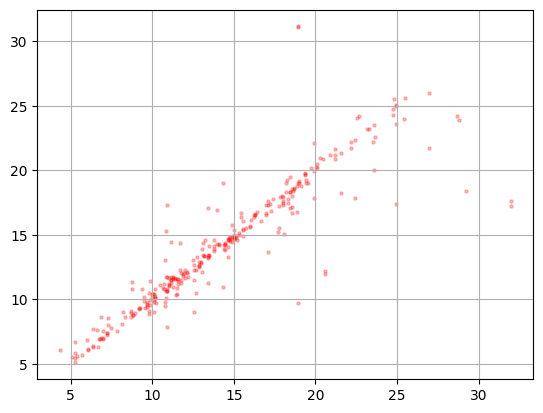

2.2746581751180335
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


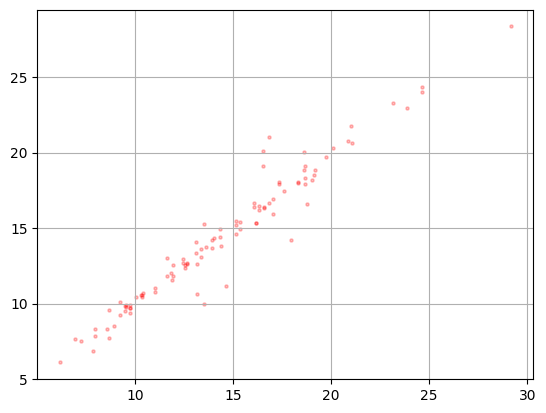

1.061345684229468
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


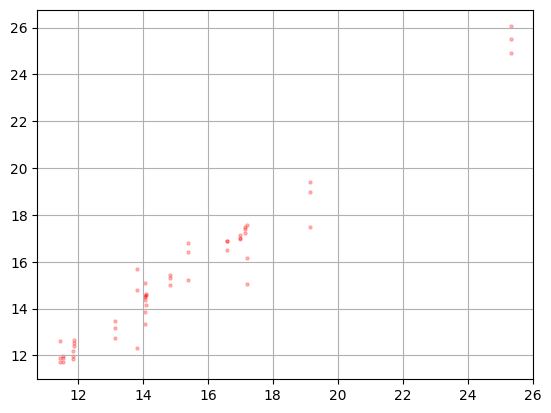

0.7208460101622042
483/483 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step


In [21]:
for i in range(7):
    
    ptestnn = modelo_cs.predict(crystalsys[f'system{i}']['x'])
    
    plt.figure()
    plt.scatter(crystalsys[f'system{i}']['y'][:,:3], ptestnn[:,:3], s=5, color='red', alpha=0.25)
    plt.grid()
    plt.show()
    
    rmse = ((ptestnn[:,:3] - crystalsys[f'system{i}']['y'][:,:3])**2).mean()**0.5
    
    res.loc['Model C', f'CS {i+1}'] = rmse
    print(rmse)
    
ptestnn = modelo_cs.predict(rctest)

rmse = ((ptestnn[:,:3] - ytest[:,:3])**2).mean()**0.5

res.loc['Model C', 'Overall'] = rmse

483/483 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step


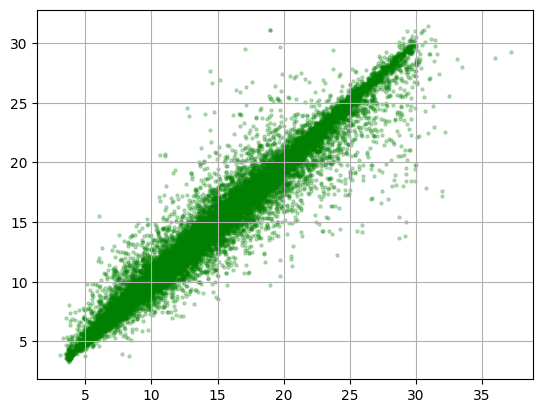

In [21]:
ptestnn = modelo_cs.predict(rctest)

rmse = ((ptestnn[:,:3] - ytest[:,:3])**2).mean()**0.5

plt.figure()
plt.scatter(ytest[:,:3], ptestnn[:,:3], s=5, color='green', alpha=0.25)
plt.grid()
plt.show()

## 3.- Model space groups (raw features + space_groups)

In [22]:
spgtest = np.concatenate((hftest, sgos_test), axis=-1)
spgtraval = np.concatenate((hftraval, sgos_traval), axis=-1)

In [24]:
features = spgtraval.shape[-1]

In [19]:
modelo_sg = create_mlp(features = features, multiples = multiples, dropout = 0.5, name='sg_mlp')

modelo_sg.compile(loss='log_cosh', metrics =['MeanSquaredError'],
                      optimizer=tf.keras.optimizers.legacy.Adamax(beta_1=0.9, beta_2=0.999, lr=1e-3, decay=1e-8,))

epochs = 25
batch_size = 64
verbose=1
saveas = 'rawnspg_model'

modelCheckpoint=tf.keras.callbacks.ModelCheckpoint(str(saveas)+'.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='auto')
history = tf.keras.callbacks.History()
data = modelo_sg.fit(spgtraval,ytraval, validation_data=(spgtest,ytest), epochs=epochs,batch_size=batch_size, callbacks=[modelCheckpoint,history],shuffle=True, verbose=verbose)


Epoch 1/25
3209/3209 [==============================] - ETA: 0s - loss: 0.2211 - mean_squared_error: 0.9955

C:\Users\lmich\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3209/3209 [==============================] - 480s 149ms/step - loss: 0.2211 - mean_squared_error: 0.9955 - val_loss: 0.1606 - val_mean_squared_error: 0.5806
Epoch 2/25
3209/3209 [==============================] - 475s 148ms/step - loss: 0.0888 - mean_squared_error: 0.2190 - val_loss: 0.1436 - val_mean_squared_error: 0.5320
Epoch 3/25
3209/3209 [==============================] - 474s 148ms/step - loss: 0.0748 - mean_squared_error: 0.1806 - val_loss: 0.1389 - val_mean_squared_error: 0.5247
Epoch 4/25
3209/3209 [==============================] - 477s 149ms/step - loss: 0.0685 - mean_squared_error: 0.1644 - val_loss: 0.1315 - val_mean_squared_error: 0.5031
Epoch 5/25
3209/3209 [==============================] - 476s 148ms/step - loss: 0.0649 - mean_squared_error: 0.1547 - val_loss: 0.1283 - val_mean_squared_error: 0.4955
Epoch 6/25
3209/3209 [==============================] - 477s 149ms/step - loss: 0.0623 - mean_squared_error: 0.1482 - val_loss: 0.1280 - val_mean_squared_error: 0.4962
Epo

In [23]:
modelo_sg = tf.keras.models.load_model('./rawnspg_model.h5')

Metrics by system

In [26]:


crystalsys = {}

for i in range(7):
    system = [dbtest.cs.values == i]
    system = np.array(system)
    system = system.reshape(15454,)
    
    crystalsys[f'system{i}'] = {'x' : spgtest[system],
                                  'y': ytest[system] }

155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


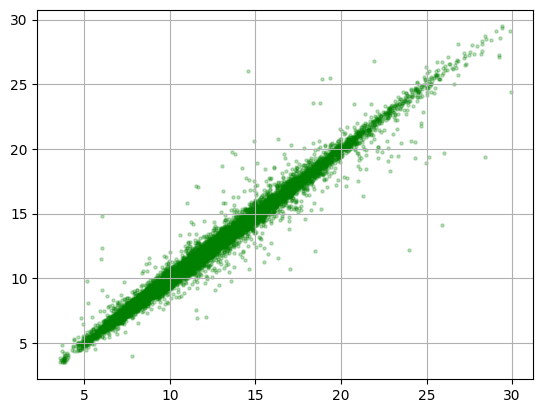

0.5450071270515768
251/251 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step


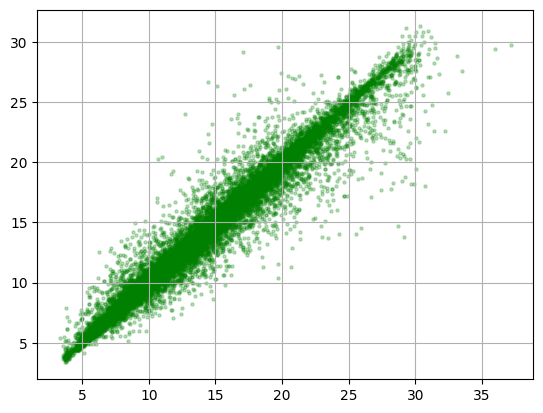

1.117415713032991
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


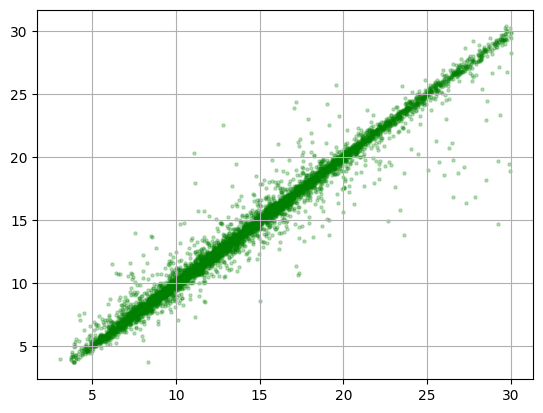

0.9025790820142136
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


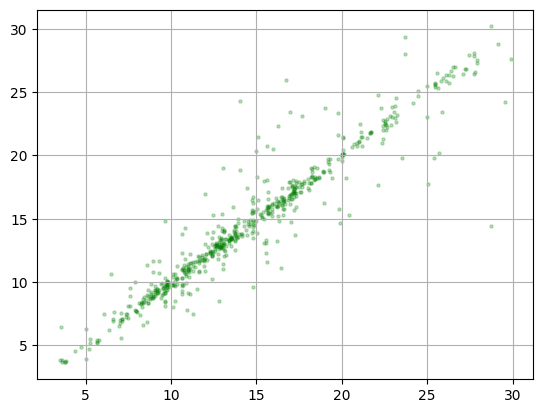

1.6330291447681489
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


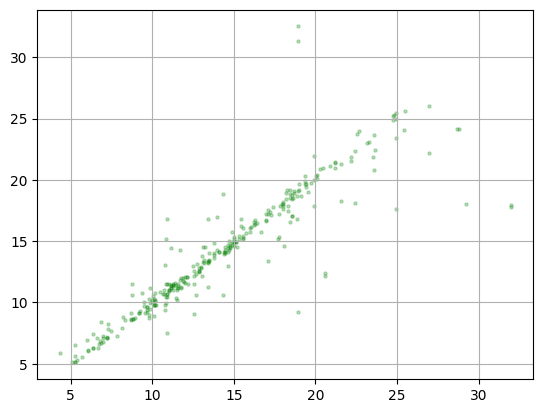

2.272949833580737
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


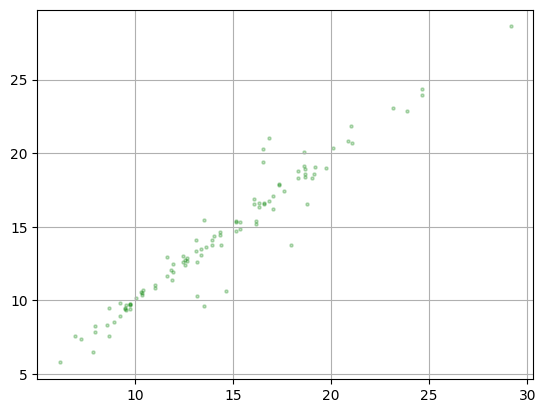

1.133251840010238
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


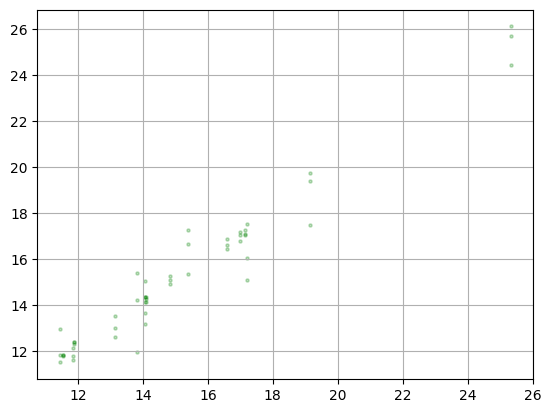

0.7491240823613708
483/483 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step


In [27]:
for i in range(7):
    
    ptestnn = modelo_sg.predict(crystalsys[f'system{i}']['x'])
    
    plt.figure()
    plt.scatter(crystalsys[f'system{i}']['y'][:,:3], ptestnn[:,:3], s=5, color='green', alpha=0.25)
    plt.grid()
    plt.show()
    
    rmse = ((ptestnn[:,:3] - crystalsys[f'system{i}']['y'][:,:3])**2).mean()**0.5
    res.loc['Model B', f'CS {i+1}'] = rmse
    print(rmse)
    
ptestnn = modelo_sg.predict(spgtest)

rmse = ((ptestnn[:,:3] - ytest[:,:3])**2).mean()**0.5

res.loc['Model B', 'Overall'] = rmse

483/483 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step


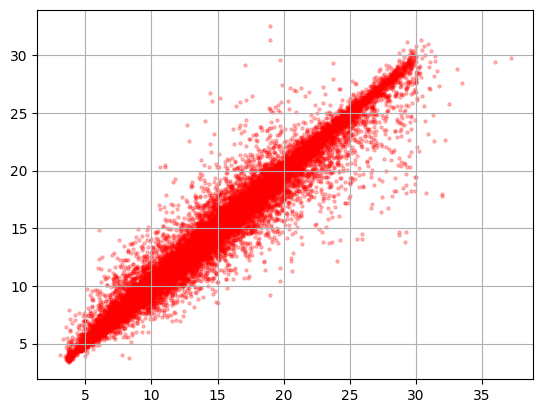

In [25]:
ptestnn = modelo_sg.predict(spgtest)

rmse = ((ptestnn[:,:3] - ytest[:,:3])**2).mean()**0.5

plt.figure()
plt.scatter(ytest[:,:3], ptestnn[:,:3], s=5, color='red', alpha=0.25)
plt.grid()
plt.show()

## 4.- By difractogram features (models extension woxrd)

In [28]:
wotest = hftest[:,:-96]
wotraval = hftraval[:,:-96]

In [30]:
wotraval.shape

(205331, 384)

In [31]:
hftraval.shape

(205331, 480)

In [32]:
features = wotraval.shape[-1]

In [15]:
multiples = [6,8]

epochs = 25
batch_size = 64
verbose=1

C:\Users\lmich\anaconda3\Lib\site-packages\keras\src\optimizers\legacy\adamax.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/25
3208/3209 [============================>.] - ETA: 0s - loss: 0.5814 - mean_squared_error: 2.9513

C:\Users\lmich\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3209/3209 [==============================] - 152s 47ms/step - loss: 0.5814 - mean_squared_error: 2.9513 - val_loss: 0.5400 - val_mean_squared_error: 3.1528
Epoch 2/25
3209/3209 [==============================] - 156s 49ms/step - loss: 0.4432 - mean_squared_error: 2.3205 - val_loss: 0.5125 - val_mean_squared_error: 3.1305
Epoch 3/25
3209/3209 [==============================] - 153s 48ms/step - loss: 0.4153 - mean_squared_error: 2.1876 - val_loss: 0.5058 - val_mean_squared_error: 3.1313
Epoch 4/25
3209/3209 [==============================] - 154s 48ms/step - loss: 0.3998 - mean_squared_error: 2.1066 - val_loss: 0.5107 - val_mean_squared_error: 3.1522
Epoch 5/25
3209/3209 [==============================] - 154s 48ms/step - loss: 0.3895 - mean_squared_error: 2.0498 - val_loss: 0.5054 - val_mean_squared_error: 3.1351
Epoch 6/25
3209/3209 [==============================] - 155s 48ms/step - loss: 0.3807 - mean_squared_error: 2.0017 - val_loss: 0.4974 - val_mean_squared_error: 3.1872
Epoch 7/2

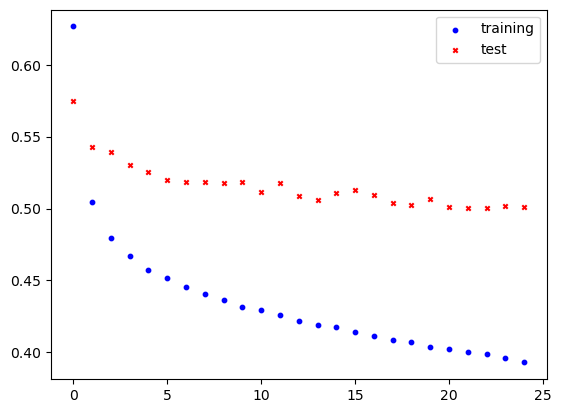

In [99]:
modelo_wo = create_mlp(features = features, multiples = multiples, dropout = 0.5, name='difracto_wo_mlp')


modelo_wo.compile(loss='log_cosh', metrics =['MeanSquaredError'],
                      optimizer=tf.keras.optimizers.legacy.Adamax(beta_1=0.9, beta_2=0.999, lr=1e-3, decay=1e-8,))

saveas = 'difracto_wo_mlp'

modelCheckpoint=tf.keras.callbacks.ModelCheckpoint(str(saveas)+'.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='auto')
history = tf.keras.callbacks.History()
data = modelo_wo.fit(wotraval,ytraval, validation_data=(wotest,ytest), epochs=epochs,batch_size=batch_size, callbacks=[modelCheckpoint,history],shuffle=True, verbose=verbose)

plt.figure()
plt.scatter(np.arange(mat.shape[0]), mat[:,0], color = 'blue', marker='o', label='training', s=10)
plt.scatter(np.arange(mat.shape[0]), mat[:,1], color = 'red', marker='x', label='test', s=10)
plt.legend(loc='best')
plt.show()

In [26]:
modelo_wo = tf.keras.models.load_model('./difracto_wo_mlp.h5')

metrics by crystal system

In [34]:
crystalsys = {}

for i in range(7):
    system = [dbtest.cs.values == i]
    system = np.array(system)
    system = system.reshape(15454,)
    
    crystalsys[f'system{i}'] = {'x' : wotest[system],
                                  'y': ytest[system] }

155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


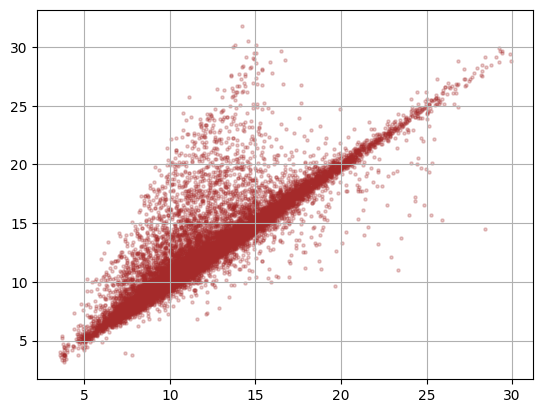

2.118195421992843
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


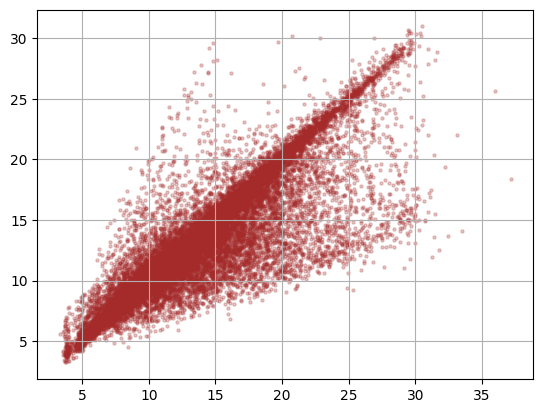

2.8298845312208996
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


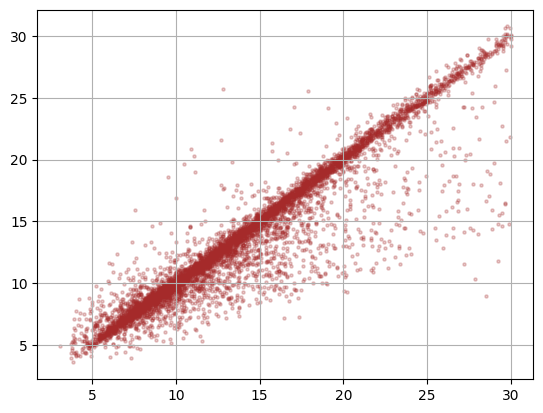

2.108922771465414
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


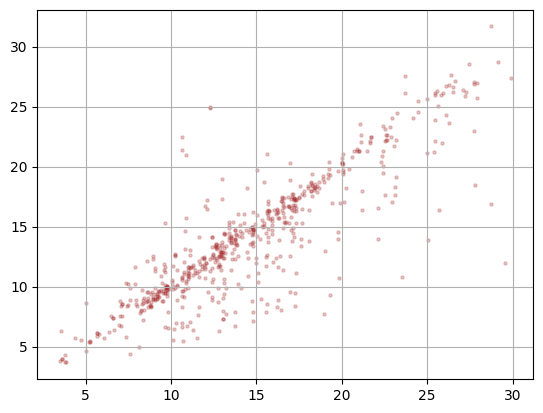

2.8370600117234943
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


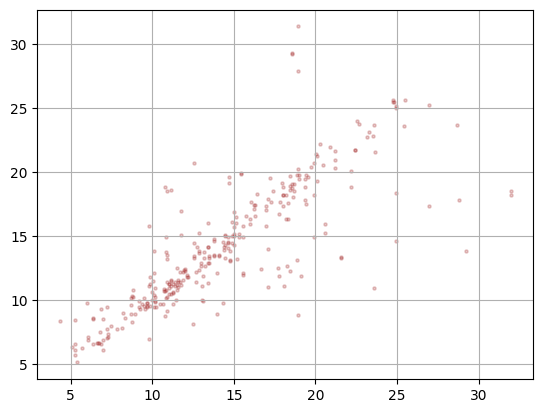

3.218397838054474
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


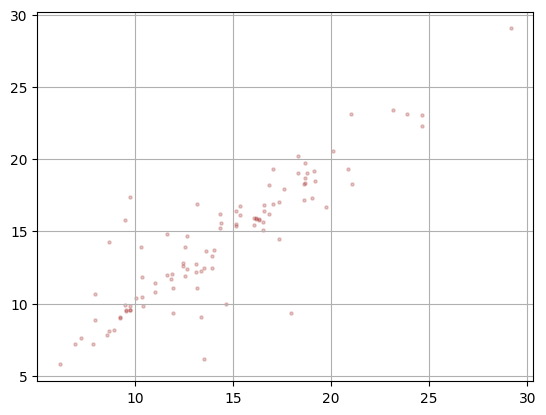

2.124048420217005
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


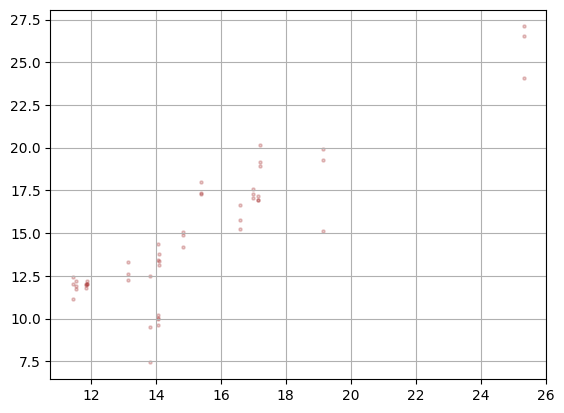

1.9332381316938143
483/483 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [35]:
for i in range(7):
    
    ptestnn = modelo_wo.predict(crystalsys[f'system{i}']['x'])
    
    plt.figure()
    plt.scatter(crystalsys[f'system{i}']['y'][:,:3], ptestnn[:,:3], s=5, color='brown', alpha=0.25)
    plt.grid()
    plt.show()
    
    rmse = ((ptestnn[:,:3] - crystalsys[f'system{i}']['y'][:,:3])**2).mean()**0.5
    res.loc['Model D', f'CS {i+1}'] = rmse
    print(rmse)
    
ptestnn = modelo_wo.predict(wotest)

rmse = ((ptestnn[:,:3] - ytest[:,:3])**2).mean()**0.5

res.loc['Model D', 'Overall'] = rmse

483/483 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


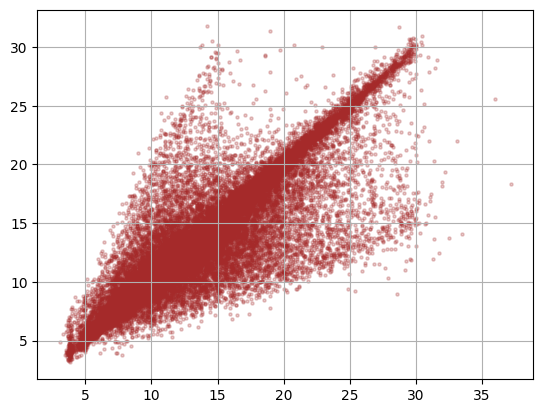

In [31]:
ptestnn = modelo_wo.predict(wotest)

rmse = ((ptestnn[:,:3] - ytest[:,:3])**2).mean()**0.5

plt.figure()
plt.scatter(ytest[:,:3], ptestnn[:,:3], s=5, color='brown', alpha=0.25)
plt.grid()
plt.show()

## 5.-difracto by space groups

In [33]:
spgtest = np.concatenate((wotest, sgos_test), axis=-1)
spgtraval = np.concatenate((wotraval, sgos_traval), axis=-1)

In [38]:
features = spgtraval.shape[-1]

In [63]:
modelo_sgwo = create_mlp(features = features, multiples = multiples, dropout = 0.5, name='sg_mlp')

modelo_sgwo.compile(loss='log_cosh', metrics =['MeanSquaredError'],
                      optimizer=tf.keras.optimizers.Adamax(beta_1=0.9, beta_2=0.999, learning_rate=1e-3, decay=1e-8,))

epochs = 25
batch_size = 64
verbose=1
saveas = 'space_woxrd'

modelCheckpoint=tf.keras.callbacks.ModelCheckpoint(str(saveas)+'.keras', monitor='val_loss', verbose=0, save_best_only=True, mode='auto')
history = tf.keras.callbacks.History()
data = modelo_sgwo.fit(spgtraval,ytraval, validation_data=(spgtest,ytest), epochs=epochs,batch_size=batch_size, callbacks=[modelCheckpoint,history],shuffle=True, verbose=verbose)


Epoch 1/25
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 526s 163ms/step - MeanSquaredError: 3.8500 - loss: 0.6549 - val_MeanSquaredError: 1.1501 - val_loss: 0.2829
Epoch 2/25
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 517s 161ms/step - MeanSquaredError: 0.7963 - loss: 0.2254 - val_MeanSquaredError: 1.0124 - val_loss: 0.2409
Epoch 3/25
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 512s 159ms/step - MeanSquaredError: 0.6575 - loss: 0.1894 - val_MeanSquaredError: 0.9622 - val_loss: 0.2297
Epoch 4/25
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 512s 159ms/step - MeanSquaredError: 0.5874 - loss: 0.1724 - val_MeanSquaredError: 0.9432 - val_loss: 0.2283
Epoch 5/25
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 514s 160ms/step - MeanSquaredError: 0.5515 - loss: 0.1626 - val_MeanSquaredError: 0.9390 - val_loss: 0.2173
Epoch 6/25
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 512s 160ms/step - MeanSquaredError: 0.5266 - loss: 0.1557 - val_MeanSquaredError: 0.9178 - val_loss: 0.2166
Epoch 7/25
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 512s 160ms/step - MeanSquaredError: 0.5077 - loss: 0.1508 

In [34]:
modelo_sgwo = tf.keras.models.load_model('./space_woxrd.keras')

155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


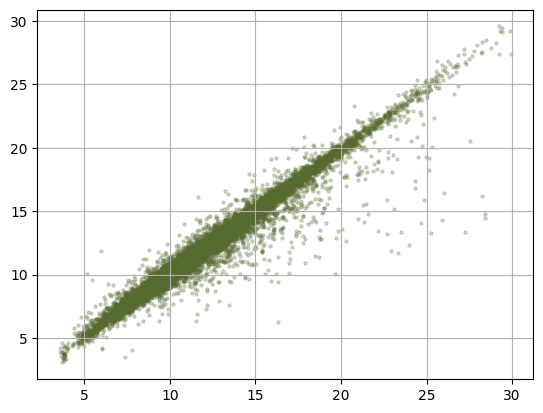

0.8016198421088708
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


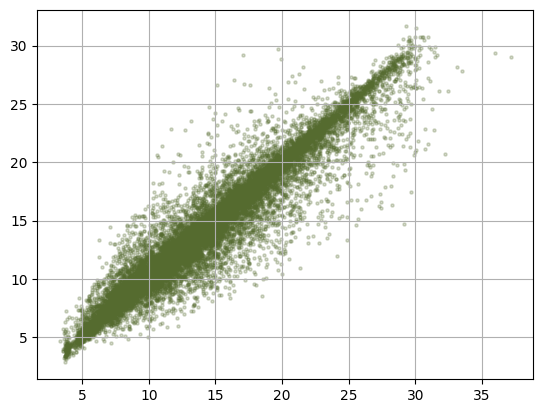

1.4957414090085146
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


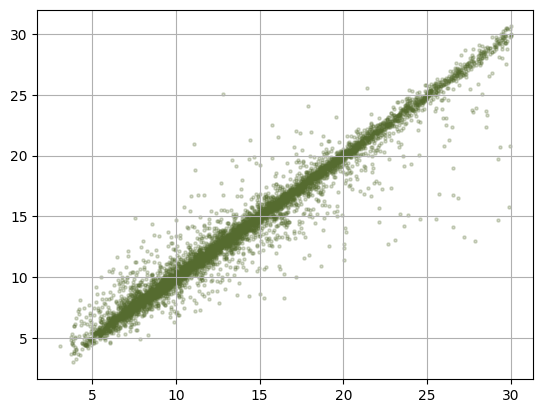

1.1925437590848103
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


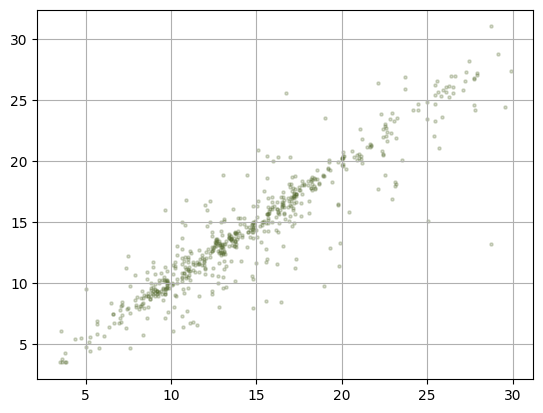

1.9981433077063904
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


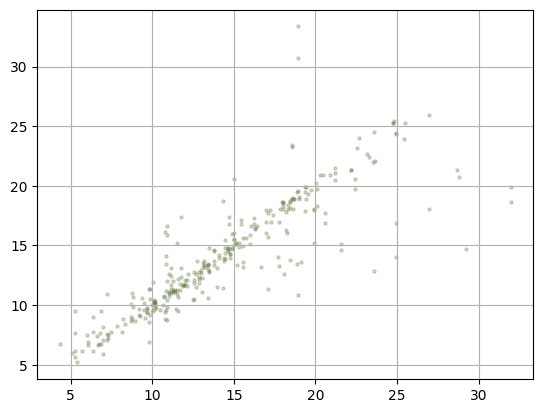

2.7651094073418805
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


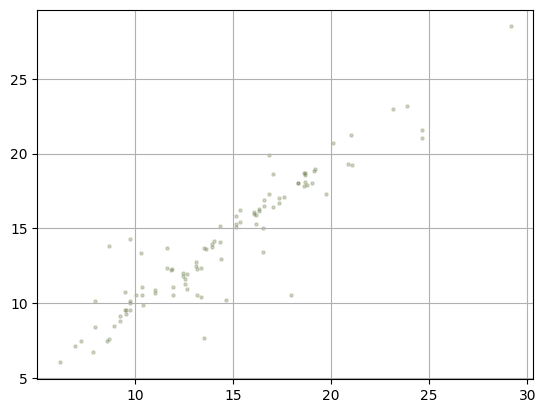

1.6754335978700263
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


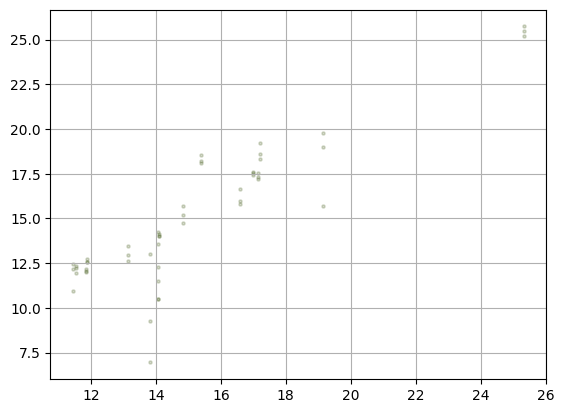

1.7571378600589997
483/483 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step


In [42]:
crystalsys = {}

for i in range(7):
    system = [dbtest.cs.values == i]
    system = np.array(system)
    system = system.reshape(15454,)
    
    crystalsys[f'system{i}'] = {'x' : spgtest[system],
                                  'y': ytest[system] }
    
for i in range(7):
    
    ptestnn = modelo_sgwo.predict(crystalsys[f'system{i}']['x'])
    
    plt.figure()
    plt.scatter(crystalsys[f'system{i}']['y'][:,:3], ptestnn[:,:3], s=5, color='darkolivegreen', alpha=0.25)
    plt.grid()
    plt.show()
    
    rmse = ((ptestnn[:,:3] - crystalsys[f'system{i}']['y'][:,:3])**2).mean()**0.5
    res.loc['Model E', f'CS {i+1}'] = rmse
    print(rmse)
    
ptestnn = modelo_sgwo.predict(spgtest)

rmse = ((ptestnn[:,:3] - ytest[:,:3])**2).mean()**0.5

res.loc['Model E', 'Overall'] = rmse

483/483 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step


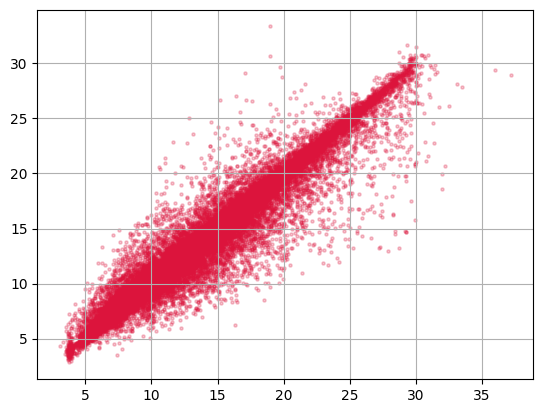

In [36]:
ptestnn = modelo_sgwo.predict(spgtest)

rmse = ((ptestnn[:,:3] - ytest[:,:3])**2).mean()**0.5

plt.figure()
plt.scatter(ytest[:,:3], ptestnn[:,:3], s=5, color='crimson', alpha=0.25)
plt.grid()
plt.show()

## 6.- By crystal systems and difractograms

In [38]:
rctest = np.concatenate((wotest, csos_test), axis=-1)
rctraval = np.concatenate((wotraval, csos_traval), axis=-1)

In [38]:
features = rctraval.shape[-1]

In [41]:
modelo_cswo = create_mlp(features = features, multiples = multiples, dropout = 0.5, name='cs_mlp')

modelo_cswo.compile(loss='log_cosh', metrics =['MeanSquaredError'],
                      optimizer=tf.keras.optimizers.legacy.Adamax(beta_1=0.9, beta_2=0.999, lr=1e-3, decay=1e-8,))

epochs = 25
batch_size = 64
verbose=1
saveas = 'crystal_wo_mlp'

modelCheckpoint=tf.keras.callbacks.ModelCheckpoint(str(saveas)+'.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='auto')
history = tf.keras.callbacks.History()
data = modelo_cswo.fit(rctraval,ytraval, validation_data=(rctest,ytest), epochs=epochs,batch_size=batch_size, callbacks=[modelCheckpoint,history],shuffle=True, verbose=verbose)

loss_log = data.history['loss']
val_loss_log = data.history['val_loss']
mat = np.vstack((loss_log, val_loss_log)).T
dataframe1 = pd.DataFrame(data=mat)
dataframe1.to_csv(str(saveas)+'.csv', sep=',', header=False, float_format='%.7f', index=False)

Epoch 1/25
3209/3209 [==============================] - 200s 62ms/step - loss: 0.4299 - mean_squared_error: 1.8554 - val_loss: 0.3448 - val_mean_squared_error: 1.6027
Epoch 2/25
3209/3209 [==============================] - 199s 62ms/step - loss: 0.2731 - mean_squared_error: 1.1123 - val_loss: 0.3157 - val_mean_squared_error: 1.5402
Epoch 3/25
3209/3209 [==============================] - 199s 62ms/step - loss: 0.2427 - mean_squared_error: 0.9748 - val_loss: 0.2998 - val_mean_squared_error: 1.4631
Epoch 4/25
3209/3209 [==============================] - 200s 62ms/step - loss: 0.2276 - mean_squared_error: 0.9066 - val_loss: 0.2896 - val_mean_squared_error: 1.4436
Epoch 5/25
3209/3209 [==============================] - 200s 62ms/step - loss: 0.2185 - mean_squared_error: 0.8646 - val_loss: 0.2862 - val_mean_squared_error: 1.4296
Epoch 6/25
3209/3209 [==============================] - 199s 62ms/step - loss: 0.2122 - mean_squared_error: 0.8367 - val_loss: 0.2907 - val_mean_squared_error: 1.479

In [39]:
modelo_cswo = tf.keras.models.load_model('./crystal_wo_mlp.h5')

155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


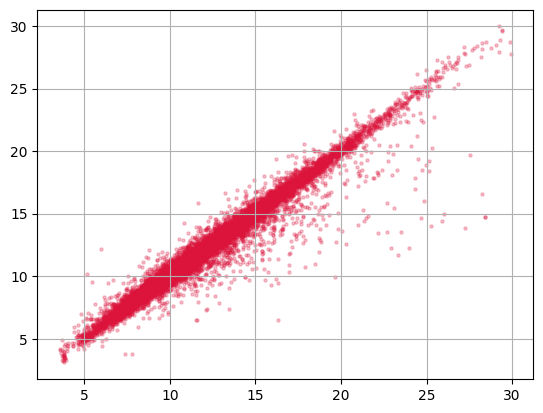

0.8096965412842676
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


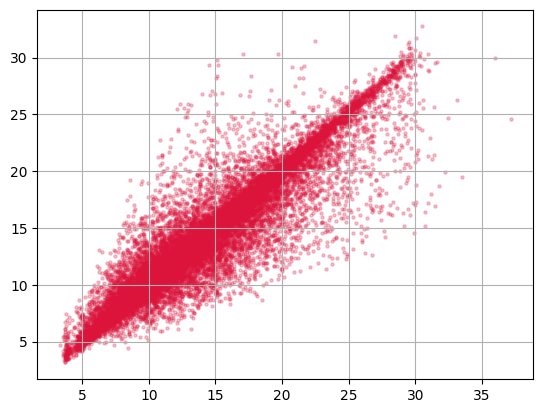

1.9981619057401674
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


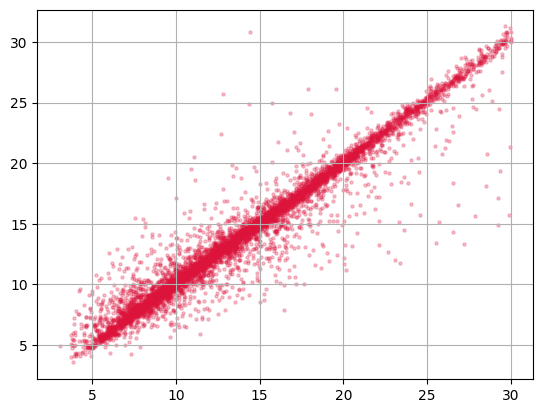

1.4382042939544222
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


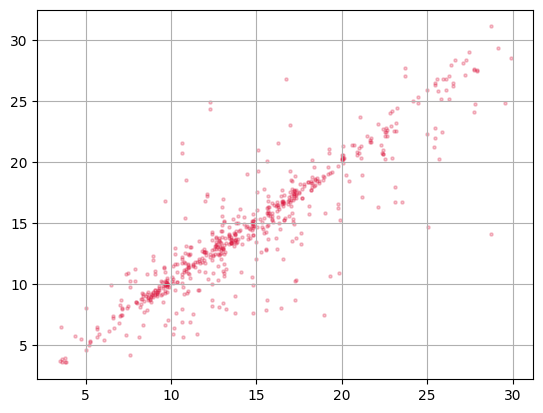

2.400445306473438
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


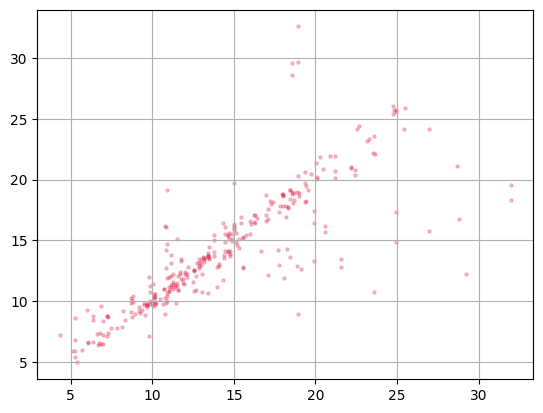

3.075123660438522
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


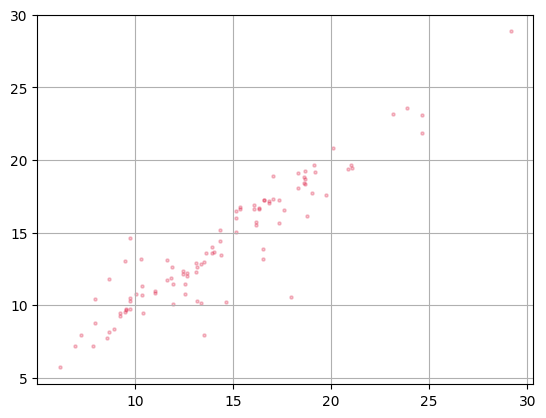

1.6617816905034546
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


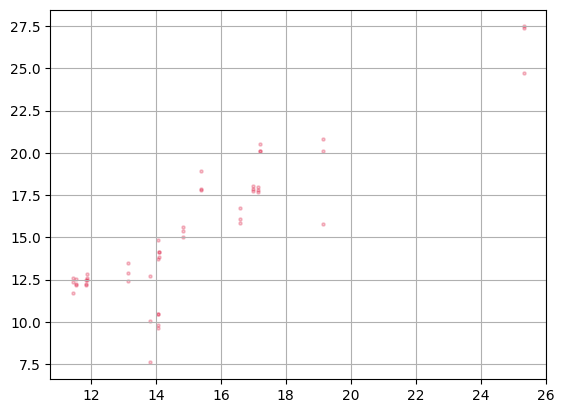

2.0226850911902283
483/483 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [46]:
crystalsys = {}

for i in range(7):
    system = [dbtest.cs.values == i]
    system = np.array(system)
    system = system.reshape(15454,)
    
    crystalsys[f'system{i}'] = {'x' : rctest[system],
                                  'y': ytest[system] }
    
for i in range(7):
    
    ptestnn = modelo_cswo.predict(crystalsys[f'system{i}']['x'])
    
    plt.figure()
    plt.scatter(crystalsys[f'system{i}']['y'][:,:3], ptestnn[:,:3], s=5, color='crimson', alpha=0.25)
    plt.grid()
    plt.show()
    
    rmse = ((ptestnn[:,:3] - crystalsys[f'system{i}']['y'][:,:3])**2).mean()**0.5
    res.loc['Model F', f'CS {i+1}'] = rmse
    print(rmse)
    
ptestnn = modelo_cswo.predict(rctest)

rmse = ((ptestnn[:,:3] - ytest[:,:3])**2).mean()**0.5

res.loc['Model F', 'Overall'] = rmse

483/483 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


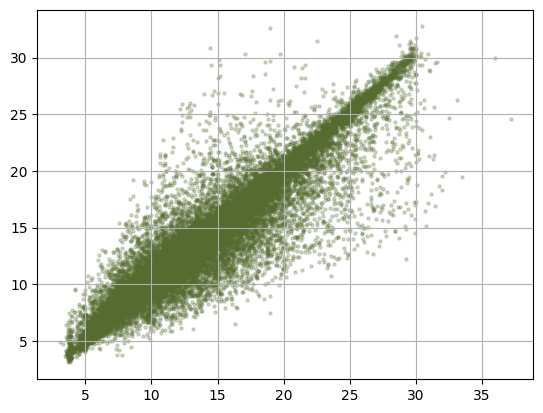

In [40]:
ptestnn = modelo_cswo.predict(rctest)

rmse = ((ptestnn[:,:3] - ytest[:,:3])**2).mean()**0.5

plt.figure()
plt.scatter(ytest[:,:3], ptestnn[:,:3], s=5, color='darkolivegreen', alpha=0.25)
plt.grid()
plt.show()

## 7. KNN Model

In [19]:
# Importando Librerias.
import tensorflow as tf

# Verificar si se está utilizando la GPU.
if tf.test.gpu_device_name():
    print('GPU encontrada.')
else:
    print("No se encontró GPU. Se utilizará la CPU.")

# Librerias adicionales:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.linear_model import LinearRegression as LR

# Librerias extra para los modelos de regresion.
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

No se encontró GPU. Se utilizará la CPU.


In [20]:
# Ejemplo de datos de entrada y salida (arrays de NumPy)
X_train_arrays = hftraval
y_train = ytraval

import time

a = time.time()
# Inicializar y entrenar un modelo de regresión KNN
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_arrays, y_train)
b = time.time()

print(f'training time:{b-a}')

# Evaluar los modelos (esto sería con datos de prueba)
X_test_arrays = hftest
y_test = ytest

predicciones_knn = knn_model.predict(X_test_arrays)

#Evaluar el rendimiento del modelo
hf_mse_knn = mean_squared_error(y_test, predicciones_knn)

#Imprimir resultados
print("Mean Squared Error KNN:", hf_mse_knn)


training time:0.031134843826293945
Mean Squared Error KNN: 0.5992365022584255


In [22]:
# Calcular el RMSE para el modelo KNN
hf_rmse_knn = np.sqrt(hf_mse_knn)\

# Imprimir resultados
print("Root Mean Squared Error KNN:", hf_rmse_knn)

Root Mean Squared Error KNN: 0.774103676685769


In [24]:
crystalsys = {}

for i in range(7):
    system = [dbtest.cs.values == i]
    system = np.array(system)
    system = system.reshape(15454,)
    
    crystalsys[f'system{i}'] = {'x' : hftest[system],
                                  'y': ytest[system] }

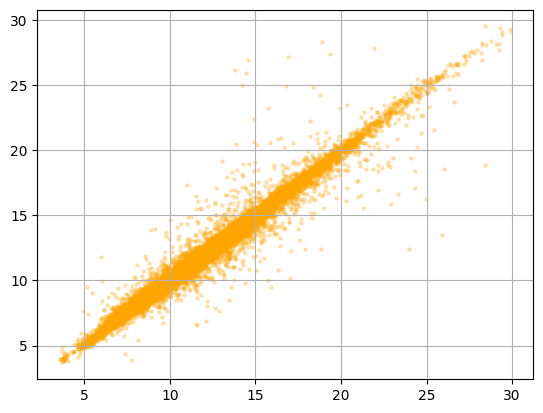

0.70608459327336


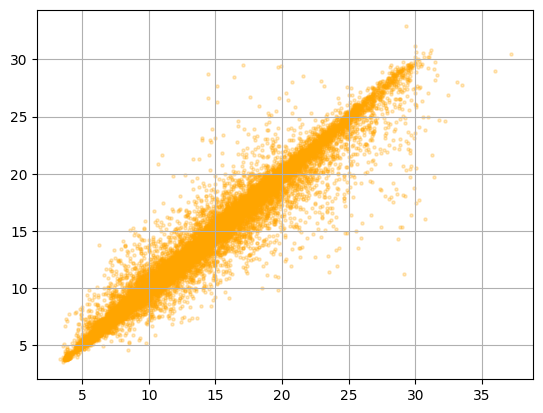

1.230928030933118


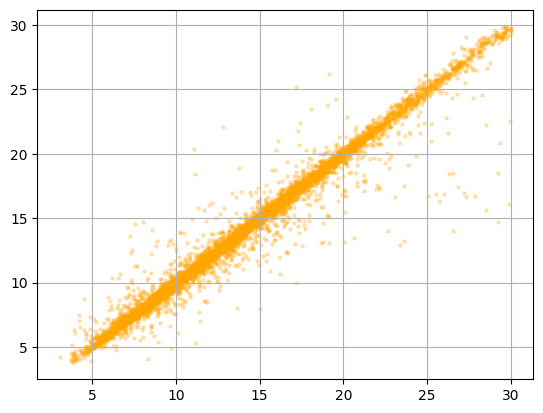

1.0060879273067782


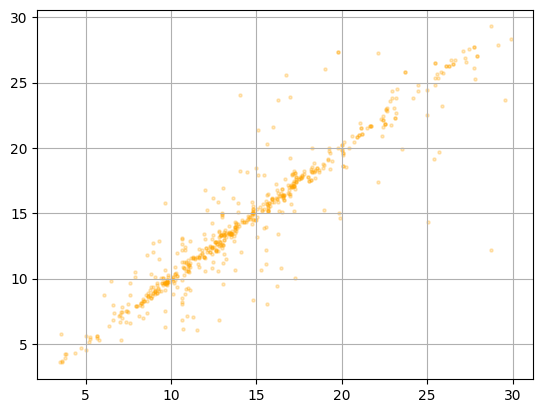

1.8952683396781367


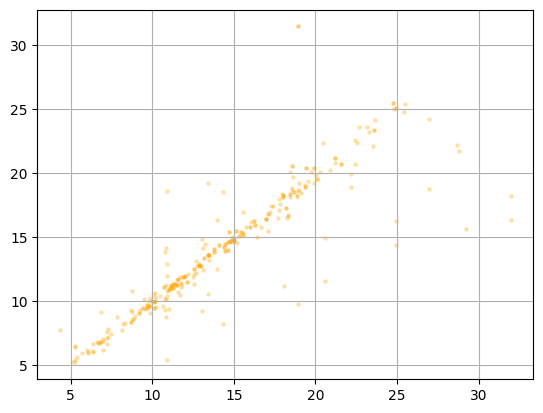

2.509433063301892


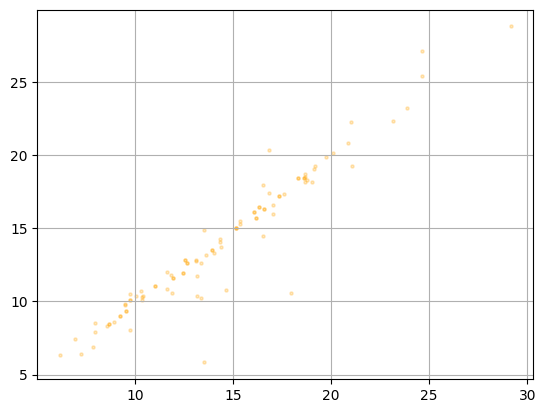

1.409661149892384


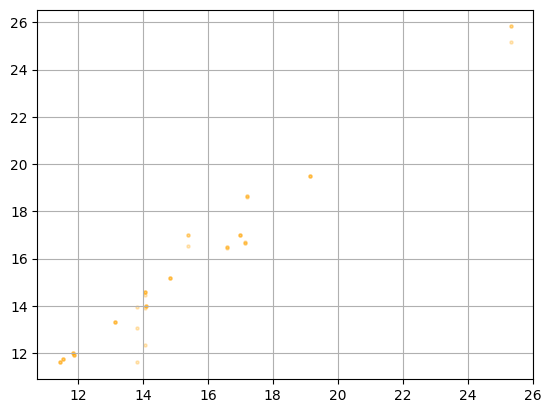

0.6896469486287216


In [25]:

for i in range(7):
    
    ptestnn = knn_model.predict(crystalsys[f'system{i}']['x'])
    
    plt.figure()
    plt.scatter(crystalsys[f'system{i}']['y'][:,:3], ptestnn[:,:3], s=5, color='orange', alpha=0.25)
    plt.grid()
    plt.show()
    
    rmse = ((ptestnn[:,:3] - crystalsys[f'system{i}']['y'][:,:3])**2).mean()**0.5
    
    print(rmse)


value6 rmse:1.084968362434823


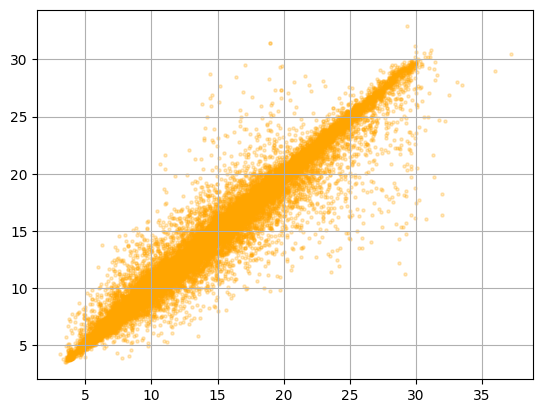

In [26]:
ptestnn = knn_model.predict(hftest)

rmse = ((ptestnn[:,:3] - ytest[:,:3])**2).mean()**0.5
print(f'value{i} rmse:{rmse}')
plt.figure()
plt.scatter(ytest[:,:3], ptestnn[:,:3], s=5, color='orange', alpha=0.25)
plt.grid()
plt.show()